## COVID-19 Chest X-ray Classification_Deep Learning Project

In [20]:
# Import Required Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# TensorFlow / Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# sklearn Libraries for Evaluation
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# Check Dataset Structure and Image Counts
import os

dataset_path = Path(r'C:\Users\Admin\Downloads\Jupyter Notes\Projects\COVID-19_Chest_X-ray_Classification\COVID-19_Radiography_Dataset')

# Classes expected in the dataset
class_names = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

# Count images per class
for cls in class_names:
    class_dir = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_dir))
    print(f"{cls}: {num_images} images")

COVID: 3616 images
Lung_Opacity: 6012 images
Normal: 10192 images
Viral Pneumonia: 1345 images


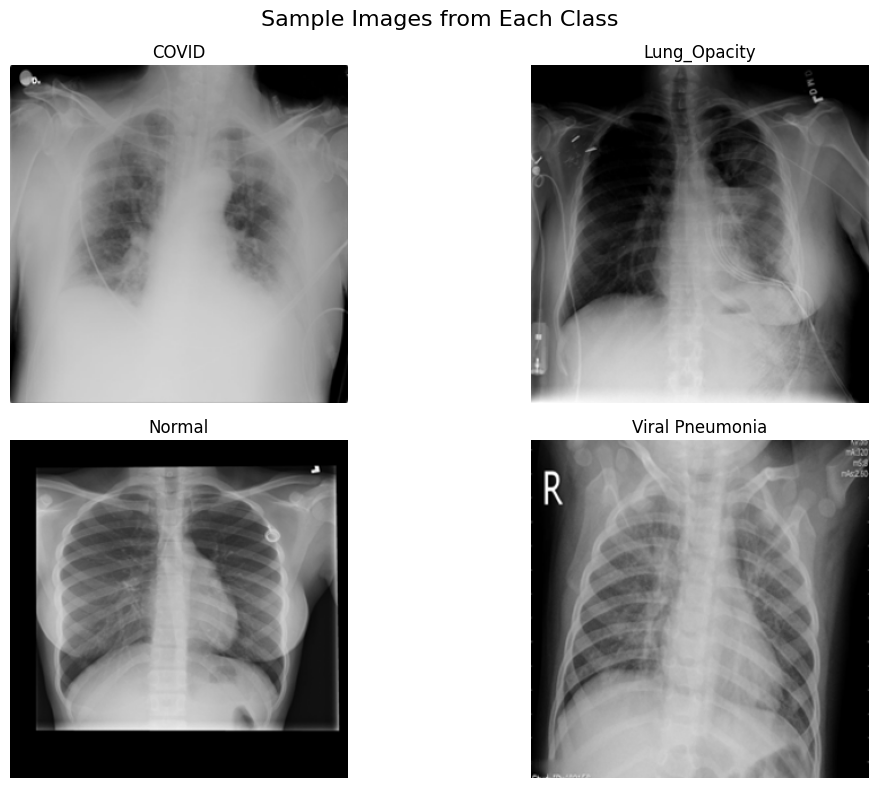

In [34]:
# Visualize Sample Images (1 per class)

# This will help you visually confirm:
#  - Image quality
#  - Image format (some are grayscale; most are RGB)
#  - Potential preprocessing needs

import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(12, 8))

for i, cls in enumerate(class_names):
    class_dir = Path(dataset_path) / cls
    image_paths = list(class_dir.rglob("*.png")) + list(class_dir.rglob("*.jpg")) + list(class_dir.rglob("*.jpeg"))
    
    if len(image_paths) == 0:
        print(f"No images found in {cls}")
        continue
    
    image_path = image_paths[0]
    img = cv2.imread(str(image_path))
    
    if img is None:
        print(f"Failed to load image: {image_path}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

In [36]:
# Image Preprocessing & Data Augmentation
# This step prepares the images for the deep learning model.

# Objective:
# - Load and preprocess images.
# - Apply data augmentation to improve generalization.
# - Split data into -> 16933 (train) + 4232 (val)-20%
#  - Training set
#  - Validation set 

# Data Augmentation -> It artificially increases dataset diversity by applying random transformations, such as: 
#  - Rotation
#  - Shifting
#  - Zooming
#  - Flipping -> This helps reduce overfitting.

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Path
dataset_path = "COVID-19_Radiography_Dataset"

# Image Settings
img_height, img_width = 224, 224  # Standard for ResNet50, EfficientNet
batch_size = 32

# Training + Validation Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values [0,1]
    rotation_range=15,             # Random rotation
    width_shift_range=0.1,         # Horizontal shift
    height_shift_range=0.1,        # Vertical shift
    zoom_range=0.1,                # Random zoom
    horizontal_flip=True,          # Flip horizontally
    validation_split=0.2           # Split for validation (20%)
)

# Training Generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Validation Generator
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [37]:
# Check Class Labels Mapping

print("Class Indices:", train_generator.class_indices)

Class Indices: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
